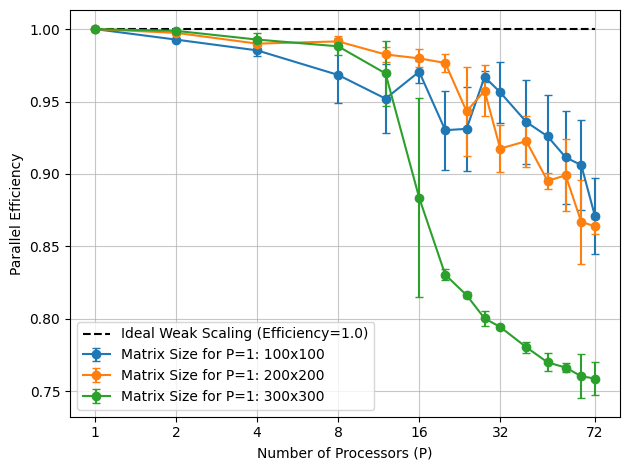

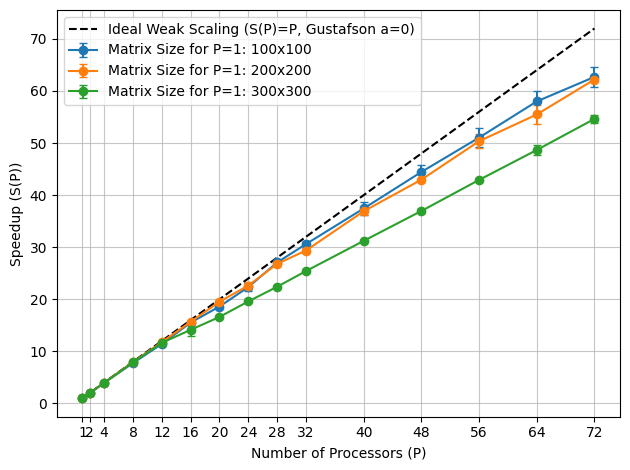

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
file_path = 'bench_results_weak_scaling/timings_weak_scaling_case1.csv'
df = pd.read_csv(file_path)

# Ensure 'procs' column is numeric and sorted for plotting
df['procs'] = pd.to_numeric(df['procs'])
df = df.sort_values(by=['local_base_size', 'procs'])

# --- 1. Efficiency Plot ---
# E = T_1 / T_N, where T_1 is the time_per_iteration for 1 processor for that local_base_size
# and T_N is the time_per_iteration for N processors for that local_base_size.

# plt.figure(figsize=(12, 7))

# Get unique local_base_sizes to plot separate curves
local_base_sizes = df['local_base_size'].unique()

for local_size in local_base_sizes:
    # Filter data for the current local_base_size
    df_local = df[df['local_base_size'] == local_size].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Calculate mean and std for time_per_iteration for each 'procs' group
    grouped_data = df_local.groupby('procs')['time_per_iteration'].agg(['mean', 'std']).reset_index()

    # Get T1 (time_per_iteration for 1 process for this local_base_size)
    # Use .iloc[0] to get the mean for procs=1
    T1_per_iter = grouped_data[grouped_data['procs'] == 1]['mean'].iloc[0]

    # Calculate efficiency: T1_per_iter / TN_per_iter
    grouped_data['efficiency'] = T1_per_iter / grouped_data['mean']
    
    # Calculate error for efficiency: (T1_per_iter / (mean - std)) - (T1_per_iter / mean) and vice versa
    # This is a propagation of error, approximating with simple ratios.
    # A more rigorous error propagation for division (A/B) is sqrt((dA/A)^2 + (dB/B)^2) * (A/B)
    # But for error bars, a simple upper/lower bound based on std is often used.
    # Let's use relative error: std_efficiency = T1_per_iter * (std_mean / mean^2)
    # Or, even simpler: error on efficiency E = T1/T_N is T1 * error_T_N / T_N^2
    # So error_bar = efficiency * (grouped_data['std'] / grouped_data['mean'])
    
    # Let's use the simpler approach: plot error on mean(time_per_iteration)
    # The error bars on efficiency would be derived from the error bars on time_per_iteration.
    # For now, let's just plot the mean and std of time_per_iteration itself, and let the efficiency scale.
    # The user asked for "T1/TN against N", and "plot error-bar", implying the error on Efficiency directly.
    # Error bar for E = T1/TN: dE = E * sqrt( (dT1/T1)^2 + (dTN/TN)^2 )
    # Since T1 is often treated as a fixed baseline for the plot, we often plot dTN/TN * E.
    # So, dE = Efficiency * (std_TN / mean_TN)
    
    # For T1, assume it's constant.
    # Error on efficiency E = T1/TN. Max(E) = T1 / (TN_mean - TN_std), Min(E) = T1 / (TN_mean + TN_std)
    # Error bar length: (Max(E) - Min(E)) / 2 or asymmetric.
    # Let's calculate symmetric error bar directly from efficiency values
    
    # Get the standard deviation of time_per_iteration (TN_std)
    std_tn = grouped_data['std']
    mean_tn = grouped_data['mean']

    # Calculate the error in efficiency based on the standard deviation of TN_per_iter
    # dE = E * (std_TN / mean_TN) (assuming dT1 is zero and only dTN contributes)
    efficiency_err = grouped_data['efficiency'] * (std_tn / mean_tn)
    
    # If std is NaN (e.g., only 1 run), replace with 0 for plotting
    efficiency_err = efficiency_err.fillna(0)

    plt.errorbar(grouped_data['procs'], grouped_data['efficiency'], 
                 yerr=efficiency_err, capsize=3, fmt='-o',
                 label=f'Matrix Size for P=1: {local_size}x{local_size}')

# Plot ideal weak scaling efficiency (constant y=1)
procs_for_ideal = np.linspace(df['procs'].min(), df['procs'].max(), 100)
plt.plot(procs_for_ideal, np.ones_like(procs_for_ideal), 'k--', label='Ideal Weak Scaling (Efficiency=1.0)')

plt.xscale('log', base=2)
# plt.xticks(df['procs'].unique(), [str(p) for p in df['procs'].unique()]) # Set xticks from actual procs values
plt.xticks([1, 2, 4, 8, 16, 32, 72], [str(p) for p in [1, 2, 4, 8, 16, 32, 72]]) # Set xticks from actual procs values
plt.ylabel('Parallel Efficiency')
plt.xlabel('Number of Processors (P)')
# plt.title('Weak Scaling: Parallel Efficiency vs. Number of Processors')
plt.grid(True, which='both', ls='-', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# --- 2. Speedup Plot ---
# Speedup = T1_per_iter * Procs / TN_per_iter = Efficiency * Procs
# Ideal Speedup = P (Gustafson's Law with a=1)

# plt.figure(figsize=(12, 7))

for local_size in local_base_sizes:
    df_local = df[df['local_base_size'] == local_size].copy()
    grouped_data = df_local.groupby('procs')['time_per_iteration'].agg(['mean', 'std']).reset_index()

    T1_per_iter = grouped_data[grouped_data['procs'] == 1]['mean'].iloc[0]

    # Calculate actual speedup
    grouped_data['speedup'] = (T1_per_iter / grouped_data['mean']) * grouped_data['procs']
    
    # Error propagation for Speedup = E * P: dS = S * sqrt((dE/E)^2 + (dP/P)^2)
    # Assuming dP=0, dS = S * dE/E = S * (Efficiency_err / Efficiency)
    # = (Efficiency * P) * (Efficiency_err / Efficiency) = P * Efficiency_err
    
    # Recalculate efficiency error for this speedup plot's context
    efficiency_err = (T1_per_iter / grouped_data['mean']) * (grouped_data['std'] / grouped_data['mean'])
    speedup_err = grouped_data['procs'] * efficiency_err
    speedup_err = speedup_err.fillna(0)


    plt.errorbar(grouped_data['procs'], grouped_data['speedup'],
                 yerr=speedup_err, capsize=3, fmt='-o',
                 label=f'Matrix Size for P=1: {local_size}x{local_size}')

# Plot ideal speedup (Gustafson's Law with a=1, which is S(P) = P)
procs_for_ideal = np.linspace(df['procs'].min(), df['procs'].max(), 100)
plt.plot(procs_for_ideal, procs_for_ideal, 'k--', label='Ideal Weak Scaling (S(P)=P, Gustafson a=1)')

# plt.xscale('log', base=2)
plt.xticks(df['procs'].unique(), [str(p) for p in df['procs'].unique()])
plt.ylabel('Speedup (S(P))')
plt.xlabel('Number of Processors (P)')
# plt.title("Weak Scaling: Speedup vs. Number of Processors (Gustafson's Law)")
plt.grid(True, which='both', ls='-', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

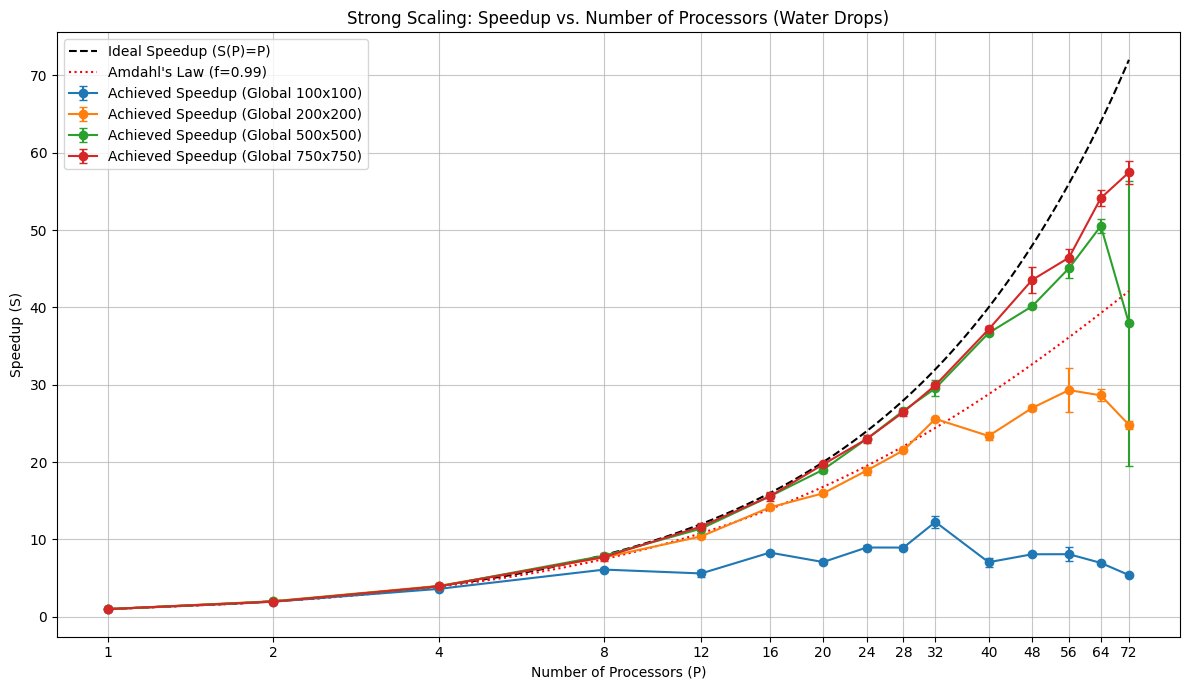

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
# Choose which strong scaling results file to plot
# Options:
# 'bench_results_case1/timings_case1.csv' for water_drops
# 'bench_results_case2/timings_case2.csv' for analytical_tsunami
# 'bench_results_case3/timings_case3.csv' for tsunami
file_path = 'bench_results_case1/timings_case1.csv'
plot_title_suffix = 'Water Drops' # e.g., 'Water Drops', 'Analytical Tsunami', 'Tsunami'

# Load the data
df_strong = pd.read_csv(file_path)

# Ensure 'procs' column is numeric and sorted for plotting
df_strong['procs'] = pd.to_numeric(df_strong['procs'])
df_strong = df_strong.sort_values(by=['global_nx', 'global_ny', 'procs'])

# --- Strong Scaling Speedup Plot (Amdahl's Law) ---

plt.figure(figsize=(12, 7))

# Get unique problem sizes to plot separate curves (global_nx, global_ny)
# Group by global_nx and global_ny to get unique problem sizes
unique_problem_sizes = df_strong[['global_nx', 'global_ny']].drop_duplicates().values

# Define the parallel fraction (f) for Amdahl's Law, as per your convention (a=0.99 is parallel part)
# Amdahl's Law Speedup S(P) = 1 / ((1-f) + f/P)
# If your 'a' is the parallel part (f), then 1-f is the sequential part.
parallel_fraction_f = 0.99 

for nx, ny in unique_problem_sizes:
    # Filter data for the current fixed problem size
    df_problem_size = df_strong[(df_strong['global_nx'] == nx) & (df_strong['global_ny'] == ny)].copy()

    # Calculate mean and std for total_time_seconds for each 'procs' group
    grouped_data = df_problem_size.groupby('procs')['total_time_seconds'].agg(['mean', 'std']).reset_index()

    # Get T1 (mean total_time_seconds for 1 processor for this problem size)
    T1_mean = grouped_data[grouped_data['procs'] == 1]['mean'].iloc[0]

    # Calculate actual speedup: S(P) = T1 / TP_mean
    grouped_data['speedup'] = T1_mean / grouped_data['mean']
    
    # Calculate error for speedup: dS = S * (std_TP / mean_TP)
    # where S is the speedup, std_TP is standard deviation of time at P procs, mean_TP is mean time at P procs
    speedup_err = grouped_data['speedup'] * (grouped_data['std'] / grouped_data['mean'])
    speedup_err = speedup_err.fillna(0) # Handle cases with NaN std (e.g., only 1 run)

    plt.errorbar(grouped_data['procs'], grouped_data['speedup'],
                 yerr=speedup_err, capsize=3, fmt='-o',
                 label=f'Achieved Speedup (Global {nx}x{ny})')

# Plot Ideal Speedup (S(P) = P)
procs_for_ideal = np.linspace(df_strong['procs'].min(), df_strong['procs'].max(), 100)
plt.plot(procs_for_ideal, procs_for_ideal, 'k--', label='Ideal Speedup (S(P)=P)')

# Plot Amdahl's Law with parallel_fraction_f
# S(P) = 1 / ((1-f) + f/P)
amdahl_speedup = 1 / ((1 - parallel_fraction_f) + parallel_fraction_f / procs_for_ideal)
plt.plot(procs_for_ideal, amdahl_speedup, 'r:', label=f'Amdahl\'s Law (f={parallel_fraction_f})')


# plt.xscale('log', base=2)
# Set xticks to only the actual processor counts from your data for cleaner labels
plt.xticks(df_strong['procs'].unique(), [str(p) for p in df_strong['procs'].unique()])
plt.ylabel('Speedup (S)')
plt.xlabel('Number of Processors (P)')
plt.title(f'Strong Scaling: Speedup vs. Number of Processors ({plot_title_suffix})')
plt.grid(True, which='both', ls='-', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()